# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

sw = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jackt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jackt\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [2]:
# Add any additional import statements you need here




In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "./M1 Results/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data:

root_path = "./M1 Results/lyrics"
lyric_data = dict()
for dir_name in os.listdir(root_path):
    if dir_name not in [".DS_Store",".ipynb_checkpoints"]:
        file_path = root_path+'/'+dir_name
        lyric_data[dir_name] = dict()
        for file_name in os.listdir(file_path):
            full_file_path = file_path+'/'+file_name
            with open(full_file_path, 'r') as f:
                text = f.read()
                title = text.split("\n")[0].strip('"')
                artist = dir_name
                lyric_data[artist][title] = text
        print(f"Read lyrics: {len(lyric_data[artist].keys())} songs of {dir_name}")
        
# Section Complete

Read lyrics: 313 songs of cher
Read lyrics: 93 songs of robyn


In [5]:
lyric_df = (pd.DataFrame(lyric_data)
            .reset_index()
            .rename(columns = {'index':'title'}))
lyric_df.loc[lyric_df['robyn'].isnull()==False,'artist'] = 'robyn'
lyric_df.loc[lyric_df['cher'].isnull()==False,'artist'] = 'cher'
lyric_df.loc[lyric_df['robyn'].isnull()==False,'lyric'] = lyric_df['robyn']
lyric_df.loc[lyric_df['cher'].isnull()==False,'lyric'] = lyric_df['cher']
lyric_df.drop(['cher','robyn'],axis = 1, inplace=True)
lyric_df.head()

# Section Complete

,title,artist,lyric
0,88 Degrees,cher,"""88 Degrees""\n\n\n\nStuck in L.A., ain't got n..."
1,A Different Kind Of Love Song,cher,"""A Different Kind Of Love Song""\n\n\n\nWhat if..."
2,After All,cher,"""After All""\n\n\n\nWell, here we are again\nI ..."
3,Again,cher,"""Again""\n\n\n\nAgain evening finds me at your ..."
4,Alfie,cher,"""Alfie""\n\n\n\nWhat's it all about, Alfie?\nIs..."


In [6]:
# Read in the twitter data:

root_path = "./M1 Results/twitter"
twitter_data = list()
for file_name in os.listdir(root_path):
    if 'data' in file_name:
        file_path = root_path+'/'+file_name
        columns = ['screen_name','name','id','location','followers_count','friends_count','description']
        df = pd.read_csv(file_path,sep='\\t',engine='python')
        df['following'] = file_name.split("_followers")[0]
        twitter_data.append(df[['following','description']])
        print(f"Read file:{file_path}",f"{df.shape[0]} rows")
        
twitter_df = pd.concat(twitter_data,axis=0).fillna(" ")
print(f"Create dataframe: {twitter_df.shape[0]} rows in total.")

# Section Complete

Read file:./M1 Results/twitter/cher_followers_data.txt 3994803 rows
Read file:./M1 Results/twitter/robynkonichiwa_followers_data.txt 358372 rows
Create dataframe: 4353175 rows in total.


In [7]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

positive_w_df = pd.read_csv("./positive-words.txt",header=None,skiprows=34,names=['word'])
positive_w_df['sentiment'] = 'positive'
positive_w_df['score'] = 1

negative_w_df = pd.read_csv("./negative-words.txt",header=None,skiprows=34,names=['word'],encoding='latin-1')
negative_w_df['sentiment'] = 'negative'
negative_w_df['score'] = -1

tidytext_df = pd.read_csv("./tidytext_sentiments.txt",sep="\t")

# Section Complete

In [8]:
positive_w_df.head()

# Section Complete

,word,sentiment,score
0,a+,positive,1
1,abound,positive,1
2,abounds,positive,1
3,abundance,positive,1
4,abundant,positive,1


In [9]:
negative_w_df.head()

# Section Complete

,word,sentiment,score
0,2-faced,negative,-1
1,2-faces,negative,-1
2,abnormal,negative,-1
3,abolish,negative,-1
4,abominable,negative,-1


In [10]:
tidytext_df.head()

# Section Complete

,word,sentiment,lexicon
0,abandon,negative,nrc
1,abandoned,negative,nrc
2,abandonment,negative,nrc
3,abba,positive,nrc
4,abduction,negative,nrc


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [11]:
# your code here:

word_dict = {}
pos_score = 1
neg_score = -1
# Adding the positive words to the dictionary
for word in positive_w_df['word'].tolist(): word_dict[word] = pos_score
# Adding the negative words to the dictionary
for word in negative_w_df['word'].tolist(): word_dict[word] = neg_score
    

In [12]:
from nltk.tokenize import word_tokenize
def sentiment_score(text):
  sentiment_score = 0
  bag_of_words = word_tokenize(text.lower()) 
  for word in bag_of_words:
    if word in word_dict:
      sentiment_score += word_dict[word]
  return sentiment_score / len(bag_of_words)

In [13]:
lyric_df['Sentiment_Score'] = lyric_df['lyric'].apply(sentiment_score)

<AxesSubplot:title={'center':'Sentiment_Score'}, xlabel='[artist]'>

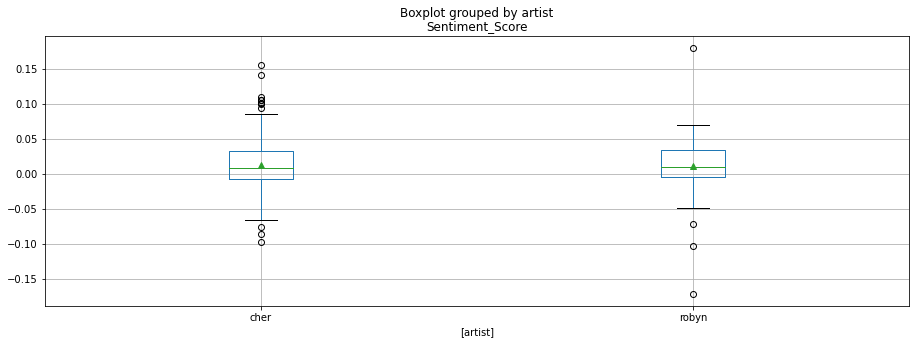

In [14]:
# check distribution - plot 1: boxplot:

lyric_df[['Sentiment_Score','artist']].boxplot(by='artist',figsize=(15,5),showmeans=True)

# Section Complete

In [15]:
lyric_df[lyric_df['artist']=='cher'].sort_values(by=['Sentiment_Score']).iloc[[0,-1]]

,title,artist,lyric,Sentiment_Score
42,Cry Myself To Sleep,cher,"""Cry Myself To Sleep""\n\n\n\nEvery night, I la...",-0.097222
177,Move Me,cher,"""Move Me""\n\n\n\nMove me\nLove the way you mov...",0.155172


In [16]:
lyric_df[lyric_df['artist']=='robyn'].sort_values(by=['Sentiment_Score']).iloc[[0,-1]]

,title,artist,lyric,Sentiment_Score
337,Don't Fucking Tell Me What To Do,robyn,"""Don't Fucking Tell Me What To Do""\n\n\n\nMy d...",-0.170354
371,Love Is Free,robyn,"""Love Is Free""\n\n\n\nFree\nLove is free, baby...",0.179894


In [17]:
# Both artists captured above, analysis below

### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: When I take a look at the means for artists it appears to be that Cher has the higher sentiment analysis score per song. I could be wrong, but that is what I am interpretting the higher mean to be.

---

Q: For your first artist, what songs have the highest and lowest sentiments? Print those songs to the screen.

A: For my first artist the lowest appears to be the song, Cry Myself to Sleep. For my first artist the highest scored song would be, My Love.

---

Q: For your second artist, what songs have the highest and lowest sentiments? Print those songs to the screen.

A: For my second artist it looks like the song, Dont F tell me what to think is the lowest and the highest would be, Love is Free.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




array([<AxesSubplot:title={'center':'cher'}>,
       <AxesSubplot:title={'center':'robyn'}>], dtype=object)

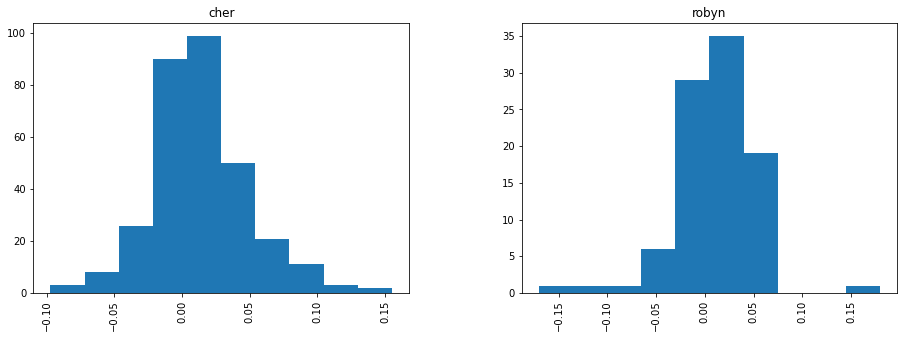

In [18]:
# check distribution plot:

lyric_df[['Sentiment_Score','artist']].hist(by='artist',figsize=(15,5))

# Section Complete

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. 

In [19]:
# your code here:

emoji_ranking_df = pd.read_csv("./Emoji_Sentiment_Data_v1.0.csv")
emoji_ranking_df['pos'] = emoji_ranking_df['Positive']/emoji_ranking_df['Occurrences']
emoji_ranking_df['neg'] = emoji_ranking_df['Negative']/emoji_ranking_df['Occurrences']
emoji_ranking_df.head(5)

,Emoji,Unicode codepoint,Occurrences,Position,Negative,Neutral,Positive,Unicode name,Unicode block,pos,neg
0,😂,0x1f602,14622,0.805101,3614,4163,6845,FACE WITH TEARS OF JOY,Emoticons,0.468130,0.247162
1,❤,0x2764,8050,0.746943,355,1334,6361,HEAVY BLACK HEART,Dingbats,0.790186,0.044099
2,♥,0x2665,7144,0.753806,252,1942,4950,BLACK HEART SUIT,Miscellaneous Symbols,0.692889,0.035274
3,😍,0x1f60d,6359,0.765292,329,1390,4640,SMILING FACE WITH HEART-SHAPED EYES,Emoticons,0.729674,0.051738
4,😭,0x1f62d,5526,0.803352,2412,1218,1896,LOUDLY CRYING FACE,Emoticons,0.343105,0.436482


In [20]:
emoji_dict = {}
pos_score = 1
neg_score = -1
neural_score = 0

# Adding the positive words to the dictionary
for idx,emo in enumerate(emoji_ranking_df['Emoji'].tolist()):
  if emoji_ranking_df['pos'][idx] > emoji_ranking_df['neg'][idx]:
    emoji_dict[emo] = pos_score
  elif emoji_ranking_df['pos'][idx] < emoji_ranking_df['neg'][idx]:
    emoji_dict[emo] = neg_score
  else:
    emoji_dict[emo] = neural_score


In [21]:
def is_emoji(text):
    return[s for s in text if s in emoji.UNICODE_EMOJI['en']]

def emoji_sentiment_score(text):
  sentiment_score = 0
  bag_of_emoji = is_emoji(text)
  if bag_of_emoji:
    for emo in bag_of_emoji:
      if emo in emoji_dict:
        sentiment_score += emoji_dict[emo]
    return sentiment_score / len(bag_of_emoji)
  else:
    return None

In [22]:
twitter_df['emoji_Sentiment_Score'] = twitter_df['description'].apply(emoji_sentiment_score)

In [23]:
twitter_df.head()

,following,description,emoji_Sentiment_Score
0,cher,,NaN
1,cher,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,NaN
2,cher,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,0.75
3,cher,csu,NaN
4,cher,Writer @Washinformer @SpelmanCollege alumna #D...,NaN


In [24]:
twitter_df.dropna(subset=['emoji_Sentiment_Score']).groupby('following')['emoji_Sentiment_Score'].mean()

following
cher              0.705995
robynkonichiwa    0.701168
Name: emoji_Sentiment_Score, dtype: float64

In [37]:
#robyn_emoji = [emo for x in twitter_df[twitter_df['following']=='robynkonichiwa'].dropna(subset=['emoji_Sentiment_Score'])['Emoji'].tolist() for emo in x]
#cher_emoji = [emo for x in twitter_df[twitter_df['following']=='cher'].dropna(subset=['emoji_Sentiment_Score'])['Emoji'].tolist() for emo in x]

# Received an error here that I could not get to properly funciton. I tried to move on past this point, but I tried to summarize the findings.

Q: What is the average sentiment of your two artists? 

A: It seems that the average sentiment is around .70 if I did the above seciton correctly.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: I was not able to get this to work.



In [ ]:
# Section Complete